![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 08. <i>Rozpoznawanie twarzy</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

W poniższych materiałach zaprezentujemy klasyczne metody rozpoznawania twarzy. Opisywane zagadnienia można odnaleźć w *5.2.3 Principal component analysis* R. Szeliski (2022) *Computer Vision: Algorithms and Applications* oraz [dokumentacji](https://docs.opencv.org/4.5.3/da/d60/tutorial_face_main.html).

Na początku załadujmy niezbędne biblioteki.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import ipywidgets
import os
import random

Rozpakujmy zbiór danych, na którym będziemy pracować:

In [2]:
!cd datasets && unzip -qo yaleextb.zip

Nasz zbiór zawiera po kilkadziesiąt zdjęć kilkudziesięciu osób, które zostały sfotografowane w różnych warunkach oświetlenia. Wczytane zdjęcia podzielimy na zbiór treningowy i testowy w stosunku 3/1 oraz wyświetlimy kilka przykładowych zdjęć:

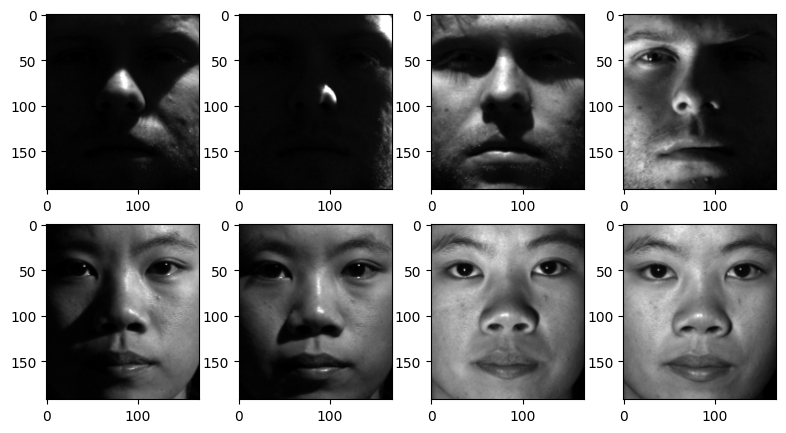

In [3]:
dataset_dir = "datasets/yaleextb"

img_data = []
img_labels = []

images = os.listdir(dataset_dir)

n_examples = 15

for i in range(1, 40):
    i_str = str(i).zfill(2)
    images_p = [img for img in images if img.startswith(f"yaleB{i_str}")]
    
    for img in images_p[:n_examples]:
        img_data.append(cv.imread(f"{dataset_dir}/{img}", cv.IMREAD_GRAYSCALE))
        img_labels.append(i)

random.seed(1337)
selector = random.choices([False, True], k=len(images), weights=[3, 1])
train_data = [x for x, y in zip(img_data, selector) if not y]
train_labels = [x for x, y in zip(img_labels, selector) if not y]
test_data = [x for x, y in zip(img_data, selector) if y]
test_labels = [x for x, y in zip(img_labels, selector) if y]

plt.figure(figsize=(12,5))
for i in range(4):
    plt.subplot(251 + i)
    plt.imshow(train_data[i], cmap='gray');
for i in range(4):
    plt.subplot(256 + i)
    plt.imshow(train_data[-i-20], cmap='gray');

Pierwszym modelem jest *Eigenfaces* zaimplementowany w [`EigenFaceRecognizer`](https://docs.opencv.org/4.5.3/dd/d7c/classcv_1_1face_1_1EigenFaceRecognizer.html). Główny pomysł polega na użyciu PCA do redukcji wymiarów. W naszym przykładzie zachowamy 60 wektorów własnych.

In [4]:
model = cv.face.EigenFaceRecognizer_create(60)
model.train(np.array(train_data), np.array(train_labels))

Zachowane wektory własne możemy zwizualizować:

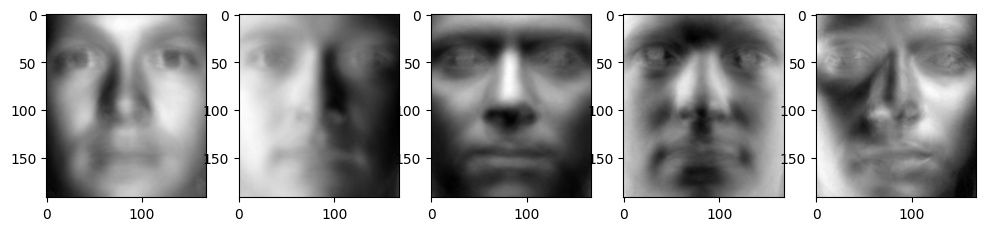

In [5]:
img_shape = train_data[0].shape
plt.figure(figsize=(12,5))
for i in range(5):
    e_v = model.getEigenVectors()[:,i]
    e_v = np.reshape(e_v, img_shape)

    plt.subplot(151+i)
    plt.imshow(e_v, cmap='gray');

Możemy zobaczyć jakie potencjalne twarze znajdują się w naszej przestrzeni. Do *uśrednionej* twarzy dodajemy kolejne wektory własne z odpowiednimi wagami. Poniżej mamy przykład wykorzystujący 6 wektorów:

In [6]:
mean = model.getMean()
W = model.getEigenVectors()

def generate_face(**args):
    img = mean.copy()
    for i, k in enumerate(args.keys()):
        img = np.add(img, W[:,i]*(10*args[k]))
    
    img = np.reshape(img, img_shape)
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray')
    plt.show()
    
ipywidgets.interactive(generate_face, 
                       w_0=ipywidgets.IntSlider(min=-128, max=128),
                       w_1=ipywidgets.IntSlider(min=-128, max=128),
                       w_2=ipywidgets.IntSlider(min=-128, max=128),
                       w_3=ipywidgets.IntSlider(min=-128, max=128),
                       w_4=ipywidgets.IntSlider(min=-128, max=128),
                       w_5=ipywidgets.IntSlider(min=-128, max=128))

interactive(children=(IntSlider(value=0, description='w_0', max=128, min=-128), IntSlider(value=0, description…

Możemy teraz spróbować zrobić rekonstrukcję np. pierwszej twarzy ze zbioru treningowego. Pobieramy dla niej projekcje (wagi) z naszego modelu i podobnie jak wyżej wykorzystujemy uśrednioną twarz i wektory własne. Możemy zobaczyć, że użycie większej liczby wektorów powoduje zwiększenie precyzji rekonstrukcji:

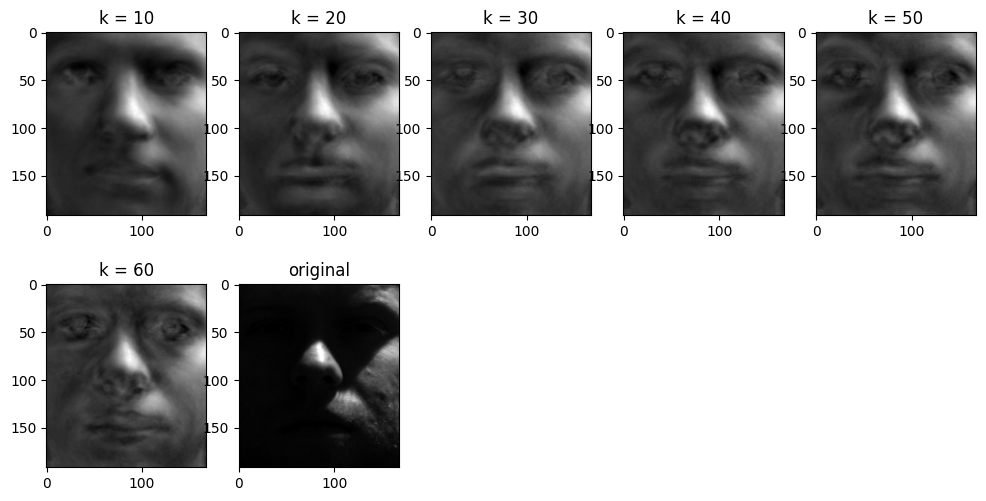

In [7]:
pro = model.getProjections()[0]

def reconstruct_face(k):
    img = mean.copy()

    for i in range(k):
        img = np.add(img, W[:,i]*pro[0,i])
        
    return img

plt.figure(figsize=(12,6))
for i in range(6):
    k = (i+1)*10
    r_face = np.reshape(reconstruct_face(k), img_shape)
    j = 0 if i <= 4 else 10
    plt.subplot(151+i+100)
    plt.imshow(r_face, cmap='gray')
    plt.title(f"k = {k}")
    
plt.subplot(257)
plt.imshow(train_data[0], cmap='gray');
plt.title("original");

Spróbujmy teraz odnaleźć osobny znajdujące się na dwóch przykładowych obrazach ze zbioru testowego. Dla nieznanej twarzy obliczamy projekcje i szukamy metodą najbliższego sąsiada projekcji ze zbioru treningowego. Poniżej mamy przykład z poprawnym rozpoznaniem osoby oraz z niepoprawnym rozpoznaniem:

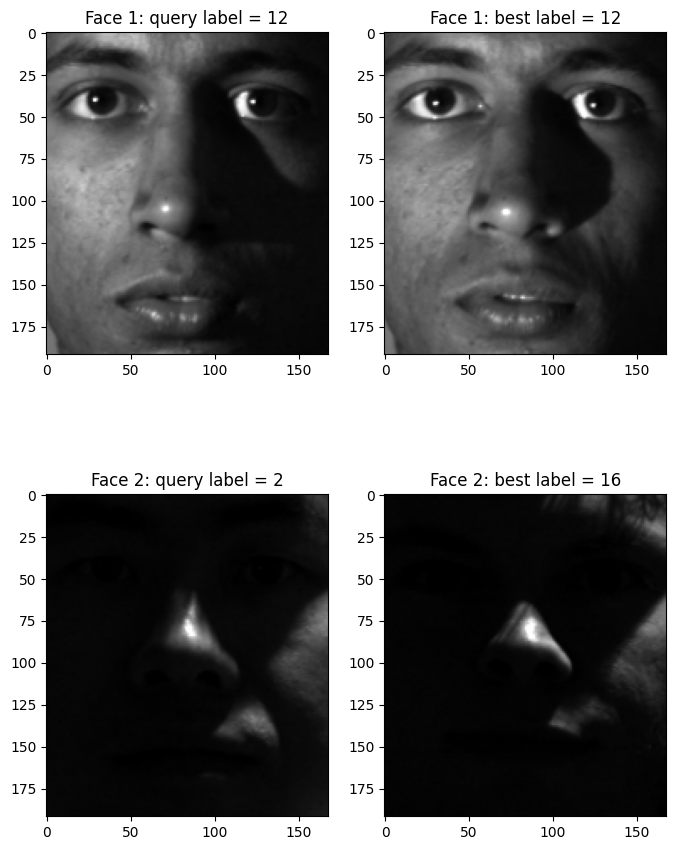

In [8]:
def find_face(query_id):
    query_face = test_data[query_id]
    query_label = test_labels[query_id]

    x = np.reshape(query_face, mean.shape)
    x_coeff = np.dot(x - mean, W)

    best_face = None
    best_label = None
    best_dist = float('inf')

    for i, p in enumerate(model.getProjections()):
        dist = np.linalg.norm(np.reshape(p, 60) - np.reshape(x_coeff, 60))

        if dist < best_dist:
            best_face = train_data[i]
            best_label = train_labels[i]
            best_dist = dist
            
    return query_face, query_label, best_face, best_label

qf_1, ql_1, bf_1, bl_1 = find_face(45)
qf_2, ql_2, bf_2, bl_2 = find_face(10)

plt.figure(figsize=(8,11))
plt.subplot(221)
plt.imshow(qf_1, cmap='gray')
plt.title(f"Face 1: query label = {ql_1}")
plt.subplot(222)
plt.imshow(bf_1, cmap='gray');
plt.title(f"Face 1: best label = {bl_1}")
plt.subplot(223)
plt.imshow(qf_2, cmap='gray')
plt.title(f"Face 2: query label = {ql_2}")
plt.subplot(224)
plt.imshow(bf_2, cmap='gray');
plt.title(f"Face 2: best label = {bl_2}");

Bardziej kompaktowe wykonanie predykcji możemy uzyskać poprzez metodę `predict()`:

In [9]:
print(test_labels[45], model.predict(test_data[45])[0])
print(test_labels[10], model.predict(test_data[10])[0])

12 12
2 16


Jak widać poniżej, metoda ta nie uzyskuje szczególnie zadowalających wyników (generalnie słabo sobie radzi w sytuacji zmian oświetlenia):

In [10]:
predictions = []
for test_img in test_data:
    p_label, p_conf = model.predict(test_img)
    predictions.append(p_label)
    
print(f"Accuracy: {sklearn.metrics.accuracy_score(test_labels, predictions) * 100:.2f} %")

Accuracy: 31.25 %


Poniżej krótko zaprezentujemy jeszcze dwa rozwinięcia tego algorytmu. Pierwszym z nich jest *Fisherfaces* zaimplementowany w [`FisherFaceRecognizer`](https://docs.opencv.org/4.5.3/d2/de9/classcv_1_1face_1_1FisherFaceRecognizer.html). Tym razem przy pomocy LDA chcemy dodatkowo uwzględnić rozrzut pomiędzy klasami (por. [przykład](https://sthalles.github.io/fisher-linear-discriminant/)). Poniżej tworzymy model z 40 komponentami:

In [11]:
model = cv.face.FisherFaceRecognizer_create(40)
model.train(np.array(train_data), np.array(train_labels))

Zauważmy, że uzyskujemy tutaj ponad dwukrotnie lepszy wynik:

In [12]:
predictions = []
for test_img in test_data:
    p_label, p_conf = model.predict(test_img)
    predictions.append(p_label)
    
print(f"Accuracy: {sklearn.metrics.accuracy_score(test_labels, predictions) * 100:.2f} %")

Accuracy: 79.86 %


Dalszym rozwinięciem jest model *Local Binary Patterns Histograms* (LBPH) zaimplementowany w [`LBPHFaceRecognizer`](https://docs.opencv.org/4.5.3/df/d25/classcv_1_1face_1_1LBPHFaceRecognizer.html). W tym wypadku chcemy np. uwzględnić możliwość innego oświetlenia osób niż taki, który występuje w naszym zbiorze treningowym. Podobnie jak wcześniej zależy nam na redukcji wymiarów, ale tym razem uzyskamy to poprzez wyliczanie cech (progowanie) dla poszczególnych pikseli w zadanych regionach.

In [13]:
model = cv.face.LBPHFaceRecognizer_create(radius=10, neighbors=10, grid_x=32, grid_y=32)
model.train(np.array(train_data), np.array(train_labels))

Uzyskany wynik jest o kilka punktów procentowy lepszy od poprzedniego modelu, jednak możemy zauważyć, że zmiana domyślnych parametrów na takie, które zwiększają precyzję, powoduje również zwiększenie czasu potrzebnego na wykonanie predykcji:

In [14]:
predictions = []
for test_img in test_data:
    p_label, p_conf = model.predict(test_img)
    predictions.append(p_label)
    
print(f"Accuracy: {sklearn.metrics.accuracy_score(test_labels, predictions) * 100:.2f} %")

Accuracy: 90.97 %


# Zadanie 1

W katalogu `datasets` znajduje się zbiór zdjęć `att_faces`. Sprawdź jakiego typu są to zdjęcia oraz jak powyższe algorytmy działają na tym zbiorze.

400
320
80


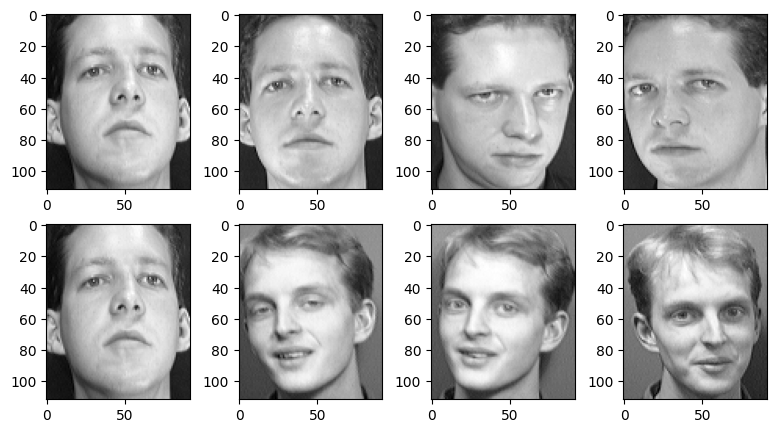

In [7]:
# miejsce na eksperymenty
import os
import random
import cv2 as cv
import matplotlib.pyplot as plt
dataset_dir = "datasets/att_faces"

img_data = []
img_labels = []

images = os.listdir(dataset_dir)
print(len(images))
n_examples = 15

for i in range(1, 41):
    i_str = str(i).zfill(2)
    images_p = [img for img in images if img.startswith(f"s{i_str}")]
    
    for img in images_p[:n_examples]:
        img_data.append(cv.imread(f"{dataset_dir}/{img}", cv.IMREAD_GRAYSCALE))
        img_labels.append(i)

random.seed(1300)
selector = random.choices([False, True], k=len(images), weights=[3, 1])
new_selector = [False for _ in range(400)]

for x in range(40):
    first_random, second_random = random.sample(range(10), 2)
    while first_random == second_random:
        second_random = random.sample(range(10), 1)
    
    new_selector[x*10 + first_random] = True
    new_selector[x*10 + second_random] = True

selector = new_selector

train_data = [x for x, y in zip(img_data, selector) if not y]
train_labels = [x for x, y in zip(img_labels, selector) if not y]

test_data = [x for x, y in zip(img_data, selector) if y]
test_labels = [x for x, y in zip(img_labels, selector) if y]

print(len(train_data))
print(len(test_data))

plt.figure(figsize=(12,5))
for i in range(4):
    plt.subplot(251 + i)
    plt.imshow(train_data[i], cmap='gray');
for i in range(4):
    plt.subplot(256 + i)
    plt.imshow(train_data[-i], cmap='gray');

In [11]:
import numpy as np
import sklearn.metrics

model = cv.face.EigenFaceRecognizer_create(60)
model.train(np.array(train_data), np.array(train_labels))

predictions = []
for test_img in test_data:
    p_label, p_conf = model.predict(test_img)
    predictions.append(p_label)
    
print(f"Accuracy: {sklearn.metrics.accuracy_score(test_labels, predictions) * 100:.2f} %")
model = cv.face.FisherFaceRecognizer_create(100)
model.train(np.array(train_data), np.array(train_labels))

predictions = []
for test_img in test_data:
    p_label, p_conf = model.predict(test_img)
    predictions.append(p_label)
    
print(f"Accuracy: {sklearn.metrics.accuracy_score(test_labels, predictions) * 100:.2f} %")

model = cv.face.LBPHFaceRecognizer_create(radius=10, neighbors=8, grid_x=8, grid_y=8)
model.train(np.array(train_data), np.array(train_labels))

predictions = []
for test_img in test_data:
    p_label, p_conf = model.predict(test_img)
    predictions.append(p_label)
    
print(f"Accuracy: {sklearn.metrics.accuracy_score(test_labels, predictions) * 100:.2f} %")


Accuracy: 95.00 %
Accuracy: 96.25 %
Accuracy: 92.50 %
